# Курс орнитологии

1. Реализуйте модель для извлечения признаков из голоса птиц. За основу можно брать:
   - преобразование в аудиофичи (например как mfcc в лекции. Конкретно это преобразование использовать нельзя)
   - обученные поверх аудиофич ML модели
  
1. С помощью модели и одного из предложенных датасетов создайте эмбеддинги пения птиц. Создайте эмбеддинги нескольких записей каждого вида птиц. Визуализируйте эмбеддинги. Для визуализации рекомендуется использовать подмножество видов птиц

1. Аргументируйте почему ваша модель хорошо извлекает признаки из аудио. 
    - Покажите кластеризацию эмбеддингов по видам

1. С помощью эмбеддингов найдите похожие по звучанию виды птиц. Выведите примеры их пения в ноутбуке.



Датасеты:
1. [Датасет](https://www.kaggle.com/vinayshanbhag/bird-song-data-set) американских птиц
1. Почищенный от фонового шума BirdCall [датасет](https://www.kaggle.com/luisblanche/birdcall-singing-3)
1. [Датасет](https://www.kaggle.com/luisblanche/birdcall-singing-0) BirdCall часть 1

In [1]:
import librosa
import librosa.display as librosa_display
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch
import pandas as pd

In [2]:
meta = pd.read_csv('data/raw/bird_songs_metadata.csv')
meta

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-8.wav
5418,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-10.wav
5419,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-14.wav
5420,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-15.wav


In [3]:
from tqdm.notebook import tqdm

filter_specs = set()
filter_specs.add('bewickii')
filter_specs.add('polyglottos')
filter_specs.add('migratorius')
meta_filt = meta[meta.species.isin(filter_specs)].sample(1000)
meta_filt

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
604,217824,Thryomanes,bewickii,NaN,Bewick's Wren,Paul Marvin,United States,"Hollenbeck Canyon Trail, Jamul, San Diego Coun...",32.6809,-116.8189,240,"call, song",//www.xeno-canto.org/217824,//creativecommons.org/licenses/by-nc-sa/4.0/,09:50,2012-03-07,NaN,217824-12.wav
1018,538537,Mimus,polyglottos,NaN,Northern Mockingbird,Paul Marvin,United States,"Proctor Valley Rd, San Diego County, California",32.6675,-116.9268,170,"mimicry/imitation, song",//www.xeno-canto.org/538537,//creativecommons.org/licenses/by-nc-sa/4.0/,07:27,2020-03-25,"imitated: California Ground Squirrel, Hooded O...",538537-10.wav
1871,57040,Mimus,polyglottos,polyglottos,Northern Mockingbird,Mike Nelson,United States,"Knoxville, Tennessee",35.8589,-84.0948,100,song,//www.xeno-canto.org/57040,//creativecommons.org/licenses/by-nc-sa/3.0/,2:45pm,2010-06-29,"Mimicry of Carolina Wren, Northern Flicker, Tu...",57040-3.wav
1397,321943,Mimus,polyglottos,polyglottos,Northern Mockingbird,Richard E. Webster,United States,"San Simon Cienega, Cochise County, Arizona",32.0840,-109.0510,1100,song,//www.xeno-canto.org/321943,//creativecommons.org/licenses/by-nc-sa/4.0/,09:24,2015-05-05,continued counter-singing to No 2; this is the...,321943-16.wav
1468,321923,Mimus,polyglottos,polyglottos,Northern Mockingbird,Richard E. Webster,United States,"San Simon Cienega, Cochise County, Arizona",32.0840,-109.0510,1100,song,//www.xeno-canto.org/321923,//creativecommons.org/licenses/by-nc-sa/4.0/,08:01,2015-05-05,No 2 of today counter-singing strongly to No 3...,321923-1.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,322887,Turdus,migratorius,NaN,American Robin,Peter Boesman,United States,"Nome, Nome, Alaska",64.5035,-165.4053,10,"call, song",//www.xeno-canto.org/322887,//creativecommons.org/licenses/by-nc-nd/4.0/,05:00,2016-06-02,NaN,322887-3.wav
1910,54019,Mimus,polyglottos,polyglottos,Northern Mockingbird,Mike Nelson,United States,"Sunset Park, Las Vegas, Nevada",36.0628,-115.1128,300,song,//www.xeno-canto.org/54019,//creativecommons.org/licenses/by-nc-sa/3.0/,9:30am,2009-03-12,NaN,54019-10.wav
411,323974,Thryomanes,bewickii,eremophilus,Bewick's Wren,Richard E. Webster,United States,"Portal, Arizona",31.9060,-109.1543,1400,song,//www.xeno-canto.org/323974,//creativecommons.org/licenses/by-nc-sa/4.0/,05:28,2015-05-01,interval shortened at 0:20; song before sunrise,323974-7.wav
1855,62791,Mimus,polyglottos,polyglottos,Northern Mockingbird,Mike Nelson,United States,"Knoxville, Tennessee",35.8589,-84.0948,300,song,//www.xeno-canto.org/62791,//creativecommons.org/licenses/by-nc-sa/3.0/,12:20pm,2010-09-30,"Imitation of: Blue Jay, Eastern Towhee, Easter...",62791-15.wav


In [4]:
"""
features = []
y = []
specs = set()
for i in tqdm(range(len(meta_filt))):
    specs.add(meta_filt.iloc[i].species)
    wav, sr = librosa.load('data/raw/wavfiles/' + meta_filt.iloc[i].filename)
    wav = librosa.effects.harmonic(wav)
    fs = librosa.feature.tonnetz(wav, sr)
    features.append(fs)
    y.append(meta_filt.iloc[i].species)
specs
"""

"\nfeatures = []\ny = []\nspecs = set()\nfor i in tqdm(range(len(meta_filt))):\n    specs.add(meta_filt.iloc[i].species)\n    wav, sr = librosa.load('data/raw/wavfiles/' + meta_filt.iloc[i].filename)\n    wav = librosa.effects.harmonic(wav)\n    fs = librosa.feature.tonnetz(wav, sr)\n    features.append(fs)\n    y.append(meta_filt.iloc[i].species)\nspecs\n"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [6]:
from transformers import Wav2Vec2Model
from transformers import Wav2Vec2Config
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2FeatureExtractor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import gc

model_outputs = []
XX = []
yy = []
specs = set()
with torch.no_grad():
    for i in tqdm(range(len(meta_filt))):
        specs.add(meta_filt.iloc[i].species)
        wav, sr = librosa.load('data/raw/wavfiles/' + meta_filt.iloc[i].filename)
        wav = librosa.resample(wav, sr, 16000)
        input_values = processor(wav, return_tensors='pt', sampling_rate=16000).input_values.to(device)
        output = model.forward(input_values).last_hidden_state[0]
        model_outputs.append(output)
        XX.append(output.mean(dim=0))
        yy.append(meta_filt.iloc[i].species)
        if i % 25 == 0:
            gc.collect()
specs

  0%|          | 0/1000 [00:00<?, ?it/s]

{'bewickii', 'migratorius', 'polyglottos'}

In [8]:
for i in range(len(model_outputs)):
    model_outputs[i] = model_outputs[i].to('cpu')
for i in range(len(XX)):
    XX[i] = XX[i].to('cpu')

In [9]:
"""
X = []
for f in features:
    f0 = torch.flatten(torch.Tensor(f))
    f1 = torch.flatten(torch.Tensor(librosa.feature.delta(f)))
    f2 = torch.flatten(torch.Tensor(librosa.feature.delta(f)))
    X.append(torch.cat([f0, f1, f2]))
"""

'\nX = []\nfor f in features:\n    f0 = torch.flatten(torch.Tensor(f))\n    f1 = torch.flatten(torch.Tensor(librosa.feature.delta(f)))\n    f2 = torch.flatten(torch.Tensor(librosa.feature.delta(f)))\n    X.append(torch.cat([f0, f1, f2]))\n'

In [10]:
# X[0].shape

In [11]:
import umap

embs = umap.UMAP().fit_transform(torch.stack(XX))

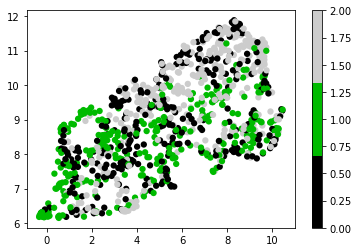

In [12]:
list_specs = list(specs)
plt.scatter(embs[:, 0], embs[:, 1],
            edgecolor='none', alpha=1, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', len(list_specs)),
            c=[list_specs.index(s) for s in yy] )
plt.colorbar()
plt.show()

In [13]:
from sklearn.cluster import KMeans, DBSCAN
clusters = KMeans(n_clusters=3, random_state=0).fit(torch.stack(XX))

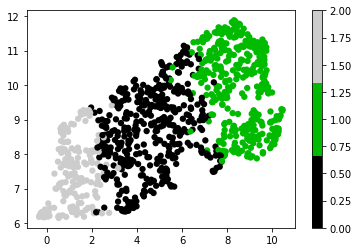

In [14]:
plt.scatter(embs[:, 0], embs[:, 1],
            edgecolor='none', alpha=1, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', len(list_specs)),
            c=clusters.labels_)
plt.colorbar()
plt.show()

In [20]:
print(list_specs[0])
print(list_specs[2])

migratorius
polyglottos


In [25]:
import numpy.linalg

bird1 = -1
for i in range(len(embs)):
    if embs[i][1] > 11.8:
        if yy[i] == list_specs[0]:
            bird1 = i

min_dist = np.inf
bird2 = -1
for i in range(len(embs)):
    dist = np.linalg.norm(embs[i] - embs[bird1])
    if yy[i] == list_specs[2] and dist < min_dist:
        min_dist = dist
        bird2 = i

max_dist = 0
bird3 = -1
for i in range(len(embs)):
    dist = np.linalg.norm(embs[i] - embs[bird1])
    if embs[i][0] > 4 and embs[i][1] > 7.5 and yy[i] == list_specs[1] and dist > max_dist and np.random.randint(0, 10) > 5:
        max_dist = dist
        bird3 = i

print(bird1)
print(bird2)
print(bird3)

771
911
983


In [26]:
import IPython
IPython.display.Audio("data/raw/wavfiles/" + meta_filt.iloc[bird1].filename)

In [27]:
IPython.display.Audio("data/raw/wavfiles/" + meta_filt.iloc[bird2].filename)

In [28]:
IPython.display.Audio("data/raw/wavfiles/" + meta_filt.iloc[bird3].filename)